In [124]:
import vsms
import importlib
importlib.reload(vsms)
import vsms.exsample_benchmark
import vsms.exsample_sampler
importlib.reload(vsms.exsample_sampler)
importlib.reload(vsms.exsample_benchmark)
import matplotlib
import matplotlib.pyplot as plt
from vsms.exsample_benchmark import *
from vsms.exsample_sampler import *

In [2]:
import pandas.api.types as pdtypes
from plotnine import *

In [3]:
from collections import namedtuple

In [4]:
from vsms.blazeit_tools import *

In [96]:
dss2 =  [BenchmarkDataset(DatasetMetadata(name='bdd_mot_labels',
                boxpath='/nvme_drive/orm/bdd_mot_labels.parquet',
                track_id='id',
                frame_id='frame_idx',
                video_len=None,
                category='category',
                categories=None,
                default_chunks=('/nvme_drive/orm/bdd_mot_frames.parquet','video_name'),
                logitpath=None,
                logitsplit=None))]

In [167]:
motf  = pd.read_parquet('/nvme_drive/orm/bdd_mot_frames.parquet')

In [179]:
(pd.Categorical(motf.video_name).codes == 1163).sum()

101

In [180]:
skvideo.io.ffprobe(trpath + '/033dea13-5a8114fe.mov')['video']['@nb_frames']

'602'

In [182]:
from IPython.display import Video
Video('http://clauslocal:8000/'+ trpath + '/033dea13-5a8114fe.mov', width=800)

In [104]:
pfix = []
for vn in motf.video_name.values:
    pfix.append(vn.split('-')[0])

In [108]:
prefix_split = pd.Series(pfix, name='prefix')

In [148]:
batch_size=50
combos = []

for ds in dss2:
    for _ in range(4):
        baselines = named_prod(
            order=['random', 'random+'],
            split=['nosplit'],
            batch_size=[batch_size],
            object_class=ds.categories,
            dataset=[ds],
            score_method=[None]
        )

        exsample = named_prod(
            order=['random+'],
            split=[prefix_split, 'default'],
            batch_size=[batch_size],
            object_class=ds.categories,
            dataset=[ds],
            score_method=[GtScore]
        )

        combos.append(baselines)
        combos.append(exsample)

In [149]:
#experiments = []
for c in combos:
    for tup in c:
        exp = Experiment.create(tup)
        experiments.append(exp)

In [150]:
from tqdm.auto import tqdm

for exp in experiments:
    Experiment.run_up_to(exp, threshold=.9)

In [151]:
res = []
for e in experiments:
    r = Experiment.get_results(e)
    res.append(r)

In [152]:
res_new = pd.concat(res)

/nvme_drive/vsms3/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/nvme_drive/vsms3/lib/python3.7/site-packages/plotnine/facets/facet.py:558: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


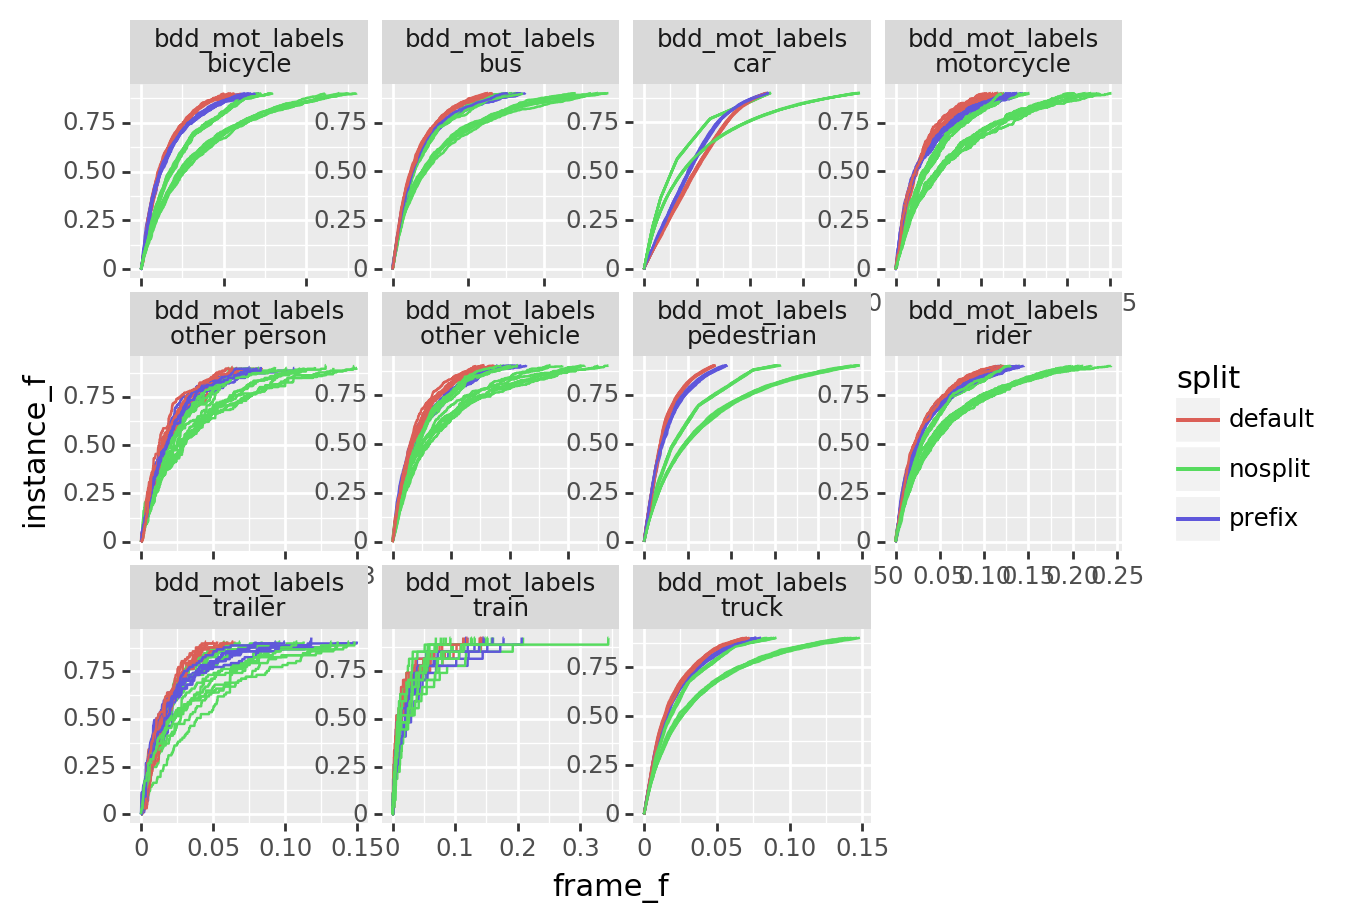

<ggplot: (8773472316413)>

In [153]:
(ggplot(res_new)
  + geom_line(aes(x='frame_f', y='instance_f', color='split', group='experiment_id'))
  + facet_wrap(facets=['dataset','object_class'], scales='free')
)

In [147]:
# res_new = res_new.assign(task=make_composite(res_new, ['dataset', 'object_class']), 
#                         method=make_composite(res_new, ['score_method', 'order', 'split']))

In [174]:
trpath = '/big_fast_drive/orm/bdd_dataset/bdd100k/videos/100k/train/'
#vds = os.listdir(trpath)
#ds._boxes.video_name.iloc[0]

In [166]:
ds.default_chunks.value_counts().sort_values()

1163    101
1090    102
44      102
729     102
730     102
       ... 
179     212
635     214
428     215
1116    246
18      263
Name: default_chunks, Length: 1400, dtype: int64

In [158]:
ds._boxes.groupby(['category', 'frame_idx']).size()

category  frame_idx
bicycle   404          1
          405          1
          406          1
          407          1
          408          1
                      ..
truck     277986       1
          277987       1
          277988       1
          277989       1
          277990       1
Length: 582018, dtype: int64

/nvme_drive/vsms3/lib/python3.7/site-packages/plotnine/facets/facet.py:558: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


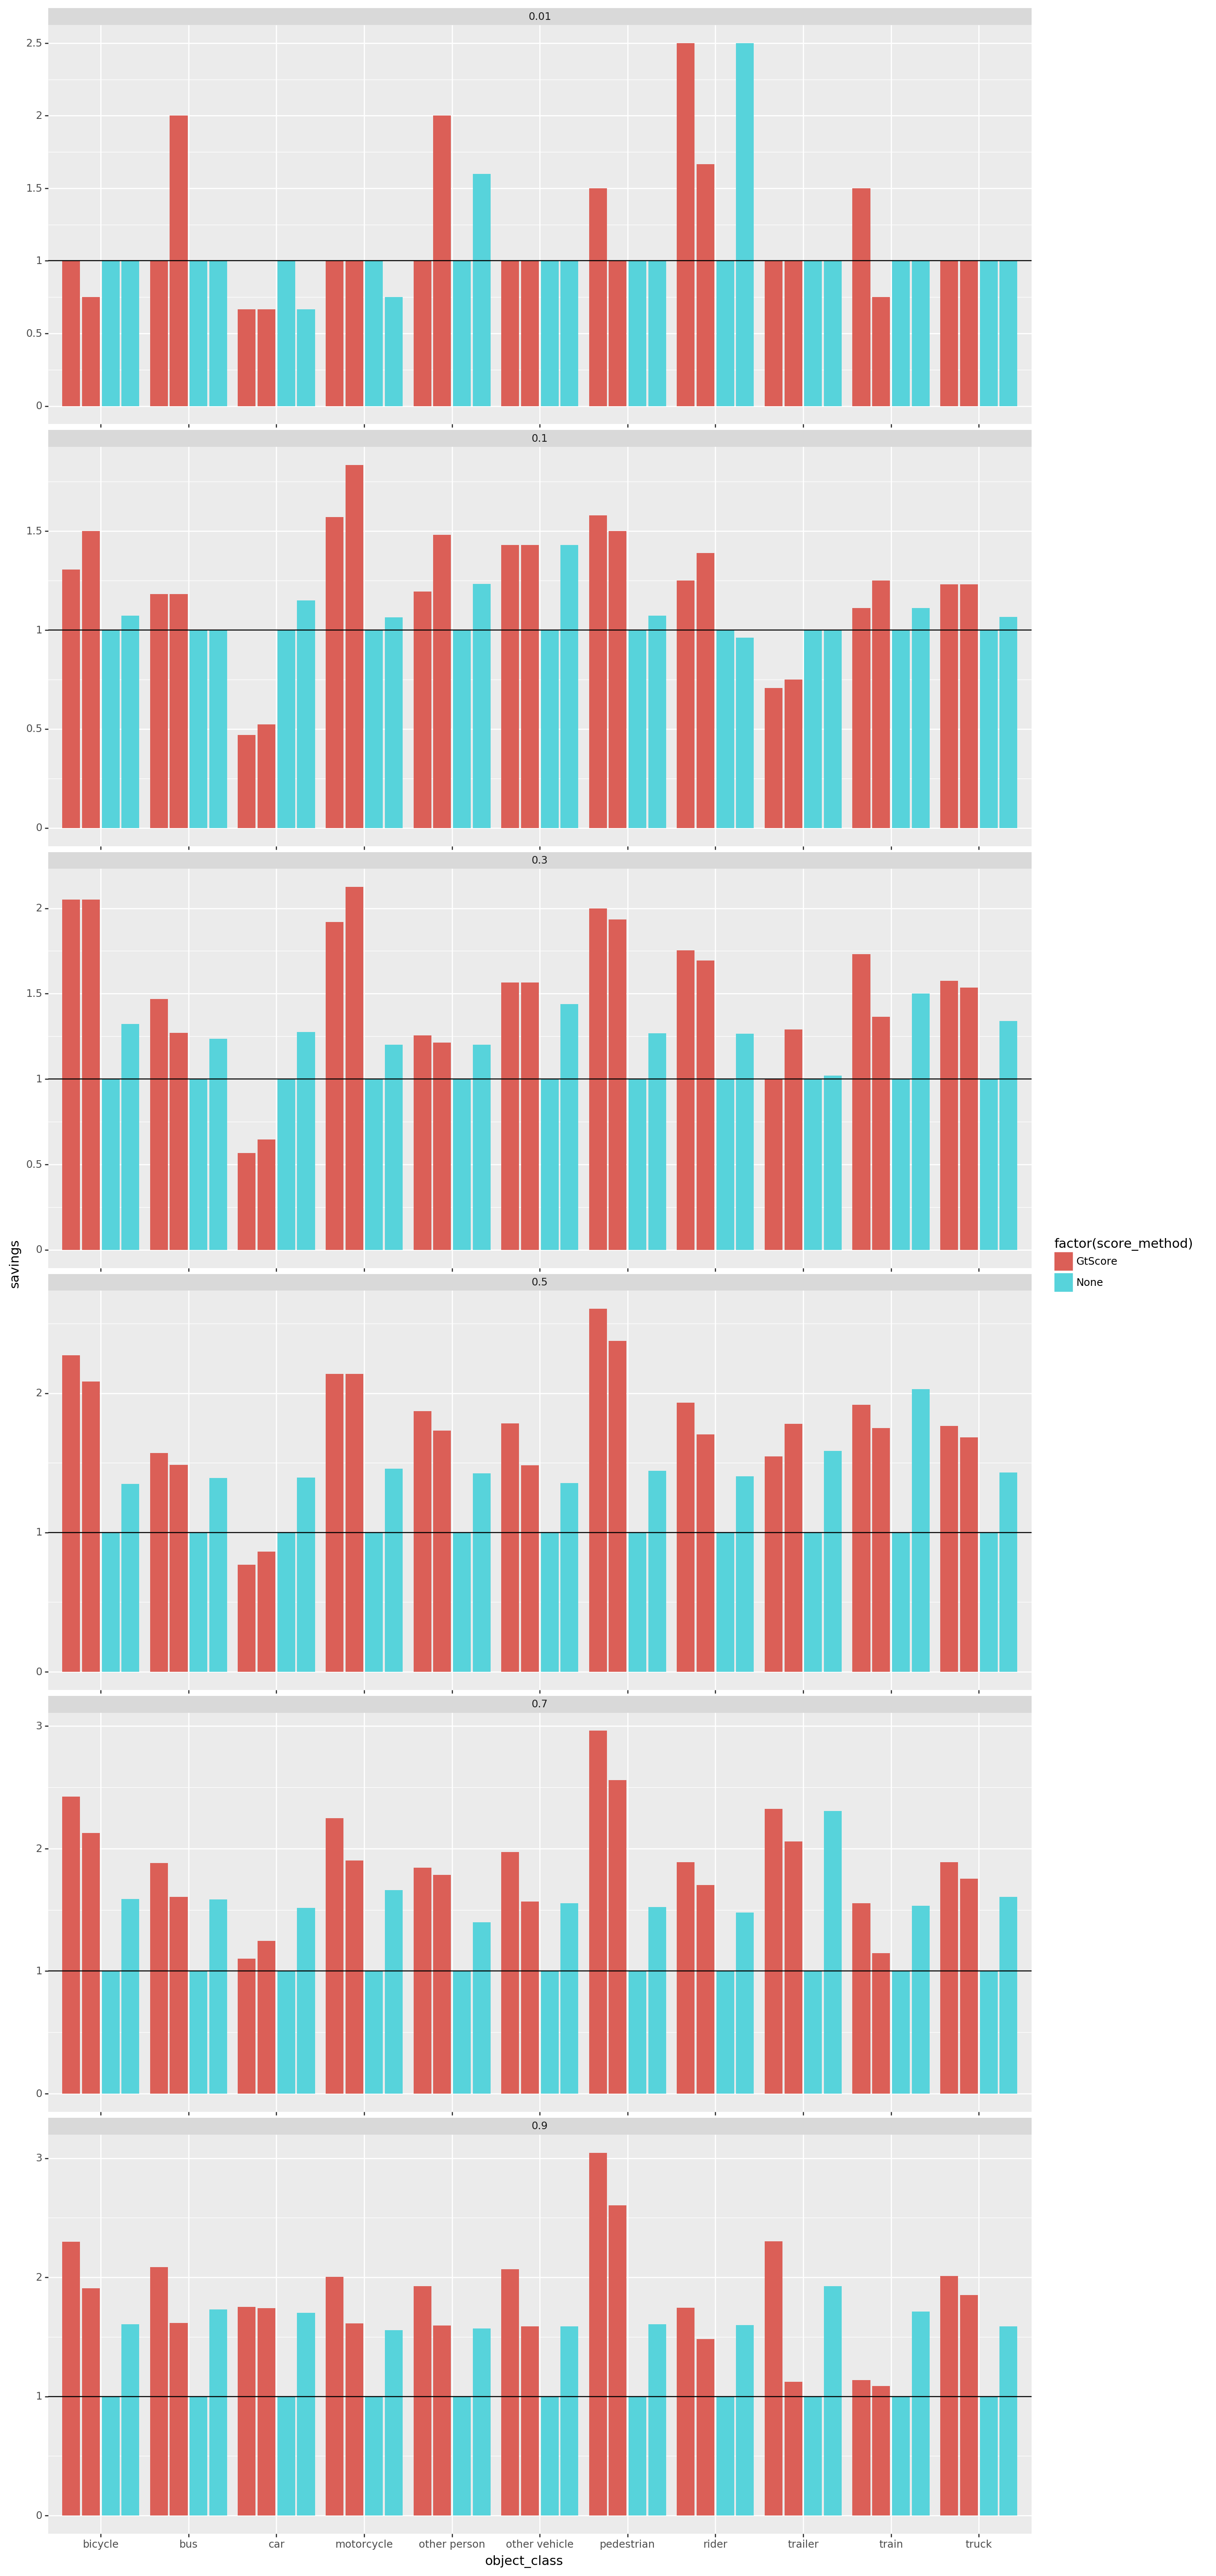

<ggplot: (8773632909958)>

In [156]:
svgs = []
for r in [.01, .1, .3, .5, .7, .9]:
    svgs.append(savings_at(res_new, ni=None, instance_f=r, task_keys=['dataset', 'object_class'], 
                           method_keys=['score_method','order', 'split'],
                          reference_method=('None', 'random', 'nosplit')).assign(recall=r))
    
svgs = pd.concat(svgs, ignore_index=True)
svgs = svgs.assign(method=make_composite(svgs, ['score_method', 'order', 'split']))

(ggplot(svgs[svgs.method != ('None', 'random', 'nosplit')])
 + geom_col(aes(x='object_class', y='savings',fill='factor(score_method)'), position=position_dodge2())
 + facet_wrap(facets=['recall'], scales='free', ncol=1)
 + theme(figure_size=(3*5,11*3.5))
 + annotate('hline', yintercept=1., color='black')
)